In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import copy
from typing import (
    Dict, 
    List,
    Any
)
import shutil


import mlflow
import warnings
from datetime import datetime

from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import StratifiedShuffleSplit

from joblib import load, dump

import shap

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\hdychko\AppData\Local\Temp\ipykernel_30236\1072598186.py:16: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))
from utils.metrics import Metrics

In [4]:
# set constants
COLS_TO_USE: List[str] = [
'OPTIN_11SCN_MLOptBin',
'G5_ND_SPECIIOptBin',
'Marital_StatusOptBin',
'SP_F2_33OptBin',
'AFF_B_09_01OptBin',
'TRD_A_20OptBin',
'TRD_A_08OptBin',
'VM01_SP_VM2_15OptBin',
'GEN11_SP_N_92OptBin',
'SP_EDI_24OptBin',
'SP_G_37OptBin',
'E4_Q_17OptBin',
'TRD_C_07OptBin',
'TRD_B_20OptBin',
'SP_B2_18OptBin',
'SPA_F2_33OptBin',
'VM01_SP_VM2_14OptBin',
'VM01_SP_VM2_24OptBin',
'SP_G_38OptBin',
'TRD_O_05OptBin',
'E1_A_09OptBin',
'TRD_O_07OptBin',
'ND_INC_03OptBin',
'VM01_SP_VM2_17OptBin',
'SP_B1_14OptBin',
'GEN11_SP_N_91OptBin',
'GEN11_SP_EDI_07OptBin',
'ND_ECC_06OptBin',
'TRD_B_18OptBin',
'TRD_B_08OptBin',
'EA5_S_01OptBin',
'CLU_CLI_L6M_NPR_L6MOptBin',
'E1_B_06OptBin',
'SP_I_67_01OptBin',
'GEN11_SP_K_80OptBin',
'SP_I_63_01OptBin',
'SP_B2_20OptBin',
'E4_Q_04OptBin',
'ND_ECC_04OptBin',
'VM08_SP_VM2_15OptBin',
'VAL_DELINQ_ACCSOptBin',
'ND_ERL_01OptBin',
'VM08_SP_VM2_20OptBin',
'EA1_D_02OptBin',
'ND_HAC_06OptBin',
'AFF_E_07_01OptBin',
'TRD_O_06OptBin',
'E2_G_08OptBin',
'AFF_T_07_01OptBin',
'VM02_SP_VM1_18OptBin'
] 

TARGET_NAME: str = 'GB6_Flag_2Limit'
TARGET_VALS: List[int] = [0, 1]
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

PALETTE: Dict[str, str] = {
    TARGET_NAME: {
        'G': 'green',
        'B': 'red',
        'I': 'black'
    },
    TARGET_BIN: {0: 'green', 1: 'red'},
    'DataPart': {'Train-val': 'orange', 'Val': 'blue', 'Test': 'black'}
    # 'Test-OOT': 'black'
}

PROJECT_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH: str = os.path.join(PROJECT_PATH, 'data')
OPT_BIN_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'optbinners')
MODELS_PATH: str = os.path.join(os.path.join(PROJECT_PATH, 'objects'), 'models')

In [5]:
N_ITER: int = 20
RANDOM_SEED: int = 42

In [6]:
# read data
df: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'final_aiq2_optbins.csv'), low_memory=False)

In [7]:
print('Number of rows: %.0f; columns: %.0f' % df.shape)

Number of rows: 110462; columns: 2069


# Preprocessing

# Convert dates to the corresponding types

In [8]:
for col in ['_RDATE_EOM', '_RDATE']:
    df[col] = pd.to_datetime(df[col]).dt.date

In [9]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

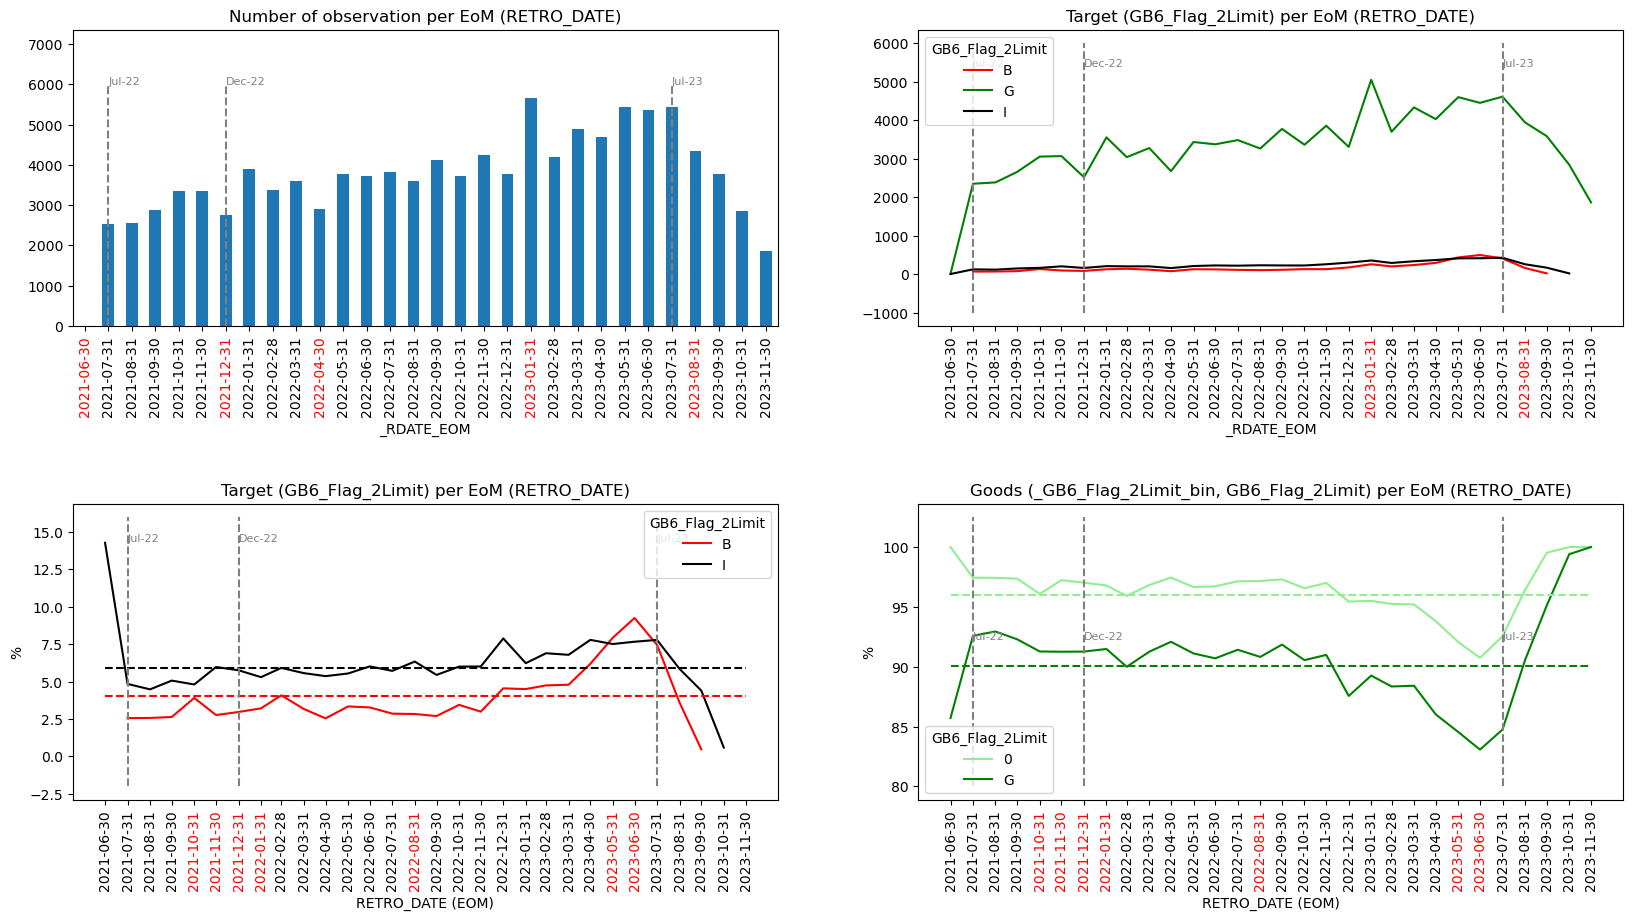

In [10]:
#  distributions 
# - number of observations per month
# - target as is, binary 
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.6)

_ = df['_RDATE_EOM'].value_counts(sort=False).sort_index().plot(kind='bar',  title='Number of observation per EoM (RETRO_DATE)', ax=ax[0, 0])

for date_val in ['2021-06-30', '2021-12-31', '2022-04-30', '2023-01-31','2023-08-31']: 
    _ = ax[0, 0].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_val).date())[0][0]].set_color("red")

_ = pd.DataFrame(df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .plot\
    .line(
        color=PALETTE[TARGET_NAME],
        title=f'Target ({TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ax=ax[0, 1]
    )
_ = ax[0, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime('2023-01-31').date())[0][0]].set_color("red")
_ = ax[0, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime('2023-08-31').date())[0][0]].set_color("red")


_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .drop(columns=['G'])\
    .plot\
    .line(
        color=PALETTE[TARGET_NAME],
        title=f'Target ({TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 0]
    )
for date_value in ['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-08-31', '2023-05-31', '2023-06-30']:
    _ = ax[1, 0].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_value).date())[0][0]].set_color("red")

_ = ax[1, 0].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['B'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color=PALETTE[TARGET_NAME]['B'], label='B-Overall', linestyle='dashed')
_ = ax[1, 0].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['I'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color=PALETTE[TARGET_NAME]['I'], label='I-Overall', linestyle='dashed')
# _ = plt.legend()

_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_BIN].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_BIN, values='n')\
    .drop(columns=[1])\
    .plot\
    .line(
        color={0: 'lightgreen', 1: 'red'},
        title=f'Target ({TARGET_BIN}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 1]
    )
_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .drop(columns=['B', 'I'])\
    .plot\
    .line(
        color={'G': 'green'},
        title=f'Goods ({TARGET_BIN}, {TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 1]
    )
for date_value in ['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-08-31', '2023-05-31', '2023-06-30']:
    _ = ax[1, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_value).date())[0][0]].set_color("red")

_ = ax[1, 1].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['G'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color='green', label='G-Overall', linestyle='dashed')
_ = ax[1, 1].hlines(y=df[TARGET_BIN].value_counts(normalize=True)[0] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color='lightgreen', label='0-Overall', linestyle='dashed')

y_values = [elem._y for elem in ax[0, 0].get_yticklabels()]
y_min, y_max = min(y_values), max(y_values)
x_vals = list(np.sort(df['_RDATE_EOM'].unique()))

_ = ax[0, 0].vlines(x=x_vals.index(pd.to_datetime('2021-07-31').date()), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
_ = ax[0, 0].annotate('Jul-22', (x_vals.index(pd.to_datetime('2021-07-31').date()), y_max), color='gray', fontsize=8)

_ = ax[0, 0].vlines(x=x_vals.index(pd.to_datetime('2021-12-31').date()), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
_ = ax[0, 0].annotate('Dec-22', (x_vals.index(pd.to_datetime('2021-12-31').date()), y_max), color='gray', fontsize=8)

_ = ax[0, 0].vlines(x=x_vals.index(pd.to_datetime('2023-07-31').date()), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
_ = ax[0, 0].annotate('Jul-23', (x_vals.index(pd.to_datetime('2023-07-31').date()), y_max), color='gray', fontsize=8)

for i in range(2):
    for j in range(2):
        y_values = [elem._y for elem in ax[i, j].get_yticklabels()]
        y_min, y_max = min(y_values), max(y_values)

        _ = ax[i, j].vlines(x=pd.to_datetime('2021-07-31').date(), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
        _ = ax[i, j].annotate('Jul-22', (pd.to_datetime('2021-07-31').date(), y_max*0.9), color='gray', fontsize=8)
        
        _ = ax[i, j].vlines(x=pd.to_datetime('2021-12-31').date(), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
        _ = ax[i, j].annotate('Dec-22', (pd.to_datetime('2021-12-31').date(), y_max*0.9), color='gray', fontsize=8)
        
        _ = ax[i, j].vlines(x=pd.to_datetime('2023-07-31').date(), ymin=y_min, ymax=y_max, color='gray', linestyle='dashed')
        _ = ax[i, j].annotate('Jul-23', (pd.to_datetime('2023-07-31').date(), y_max*0.9), color='gray', fontsize=8)


In [11]:
TRAIN_FROM: datetime.date = pd.to_datetime('2021-12-01').date()
TRAIN_TO: datetime.date = pd.to_datetime('2022-01-01').date()

VAL_FROM: datetime.date = pd.to_datetime('2022-01-01').date()
VAL_TO: datetime.date = pd.to_datetime('2022-05-01').date()

TEST_FROM: datetime.date = pd.to_datetime('2022-05-01').date()
TEST_TO: datetime.date = pd.to_datetime('2022-08-01').date()

In [12]:
df_train = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < TRAIN_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_train_val = df.loc[
    (df._RDATE >= TRAIN_FROM) &
    (df._RDATE < VAL_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_val = df.loc[
    (df._RDATE >= VAL_FROM) &
    (df._RDATE < VAL_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

df_test = df.loc[
    (df._RDATE >= TEST_FROM) &
    (df._RDATE < TEST_TO),
    COLS_TO_USE + [TARGET_NAME, TARGET_BIN, '_RDATE']
].reset_index(drop=True)

In [13]:
data_dict = {
    "df_train": df_train,
    "df_val": df_val,
    "df_train_val": df_train_val, 
    "df_test": df_test
}

In [14]:
# randomly select N observations from test data
N = 10000
sss = StratifiedShuffleSplit(n_splits=1, train_size=N, random_state=RANDOM_SEED)
indx = sss.split(data_dict['df_test'].reset_index(drop=True), data_dict['df_test'][TARGET_BIN])
random_indx = list(indx)[0][0]

assert len(random_indx) == N, "Incorrect number of elements in the subsample"
test_sample = data_dict['df_test'].reset_index(drop=True).iloc[random_indx, :].reset_index(drop=True)

In [15]:
data_dict['df_test_sample'] = test_sample

In [16]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")
mlflow.set_experiment("[Experian]")

<Experiment: artifact_location='mlflow-artifacts:/696858428304145414', creation_time=1716463645799, experiment_id='696858428304145414', last_update_time=1716463645799, lifecycle_stage='active', name='[Experian]', tags={}>

In [17]:
MODEL = LogisticRegression

In [18]:
experiment_description = f"""
    'features': {len(COLS_TO_USE)},
    'target': {TARGET_BIN},
    'target_vals': '0, 1',
    'model': {MODEL.__name__},
    'data_version': '22.05.2024', 
    'train_period': [{TRAIN_FROM.strftime('%Y-%m-%d') + ', ' + TRAIN_TO.strftime('%Y-%m-%d')}),
    'val_period': [{VAL_FROM.strftime('%Y-%m-%d') + ', ' + VAL_TO.strftime('%Y-%m-%d')}),
    'test_period': [{TEST_FROM.strftime('%Y-%m-%d') + ', ' + TEST_TO.strftime('%Y-%m-%d')}),
"""

In [19]:
print(experiment_description)


    'features': 50,
    'target': _GB6_Flag_2Limit_bin,
    'target_vals': '0, 1',
    'model': LogisticRegression,
    'data_version': '22.05.2024', 
    'train_period': [2021-12-01, 2022-01-01),
    'val_period': [2022-01-01, 2022-05-01),
    'test_period': [2022-05-01, 2022-08-01),



In [21]:
PARAMS = dict(
    penalty=['l2', 'l1', 'elasticnet'], 
    C=uniform(loc=0, scale=20), 
    fit_intercept=[True], 
    class_weight=['balanced'], 
    random_state=[RANDOM_SEED], 
    n_jobs=[-1]
)

In [22]:
def generate_params_dict_from_distributions(distributions: Dict[str, Any]) -> Dict[str, Any]:
    params = dict.fromkeys(distributions.keys())
    for kye_param in distributions.keys():
        if (type(distributions[kye_param]) == list) | (type(distributions[kye_param]) == np.ndarray):
            i = np.random.randint(len(distributions[kye_param]))
            params[kye_param] = distributions[kye_param][i]
        else:
            params[kye_param] = distributions[kye_param].rvs()
    return params

In [23]:
def update_solver_by_penalty(params: Dict[str, Any]):
    solvers_penalty = {
        'l2': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        'l1': ['liblinear', 'saga'],
        'elasticnet': ['saga']
    }
    n_solvers = len(solvers_penalty[params['penalty']])
    ind = np.random.choice(np.arange(n_solvers), 1)[0]
    params['solver'] = solvers_penalty[params['penalty']][ind]

    if params['penalty'] == 'elasticnet':
        params['l1_ratio'] = uniform(loc=0, scale=1).rvs()
    return params

In [79]:
def search_hyper_params_and_log(run_name: str, 
                                data_dict: Dict[str, pd.DataFrame],
                                cols_to_use: List[str],
                                target_name: str,
                                distributions: Dict[str, Any],
                                n_iter: int,
                                model: Any,
                                custom_params_updates=None, 
                                tags: Dict[str, str]=None
                               ) -> pd.DataFrame:
       
    res: List[Dict[str, Any]] = []
    pr_auc: List[float] = []
    gini_vals: List[float] = []
    np.random.seed(distributions['random_state'][0])
    for i in range(n_iter):
        print(f"# {i + 1} / {n_iter}")
       
        # generate parameters
        params = generate_params_dict_from_distributions(distributions)
        if custom_params_updates is not None:
            params = custom_params_updates(params)

        X_train = data_dict['df_train'][cols_to_use]
        Y_train = data_dict['df_train'][target_name]
        X_val = data_dict['df_val'][cols_to_use]
        Y_val = data_dict['df_val'][target_name]

        std_scaler = StandardScaler()
        std_scaler.fit(X_train)
        X_train = std_scaler.transform(X_train)
        X_val = std_scaler.transform(X_val)

        model_obj = model(**params)
        model_obj.fit(X_train, Y_train)
        y_val_pred = model_obj.predict_proba(X_val)[:, 1]

        roc_auc_val = roc_auc_score(Y_val.astype(int), y_val_pred)
        gini_val = 2 * roc_auc_val - 1
        
        precision, recall, _ = precision_recall_curve(Y_val.astype(int), y_val_pred)
        auc_values = auc(x=recall, y=precision)
        pr_auc += [auc_values]
        gini_vals += [gini_val]

        res += [{"params": params, "PR_AUC": auc_values, "GINI": gini_val}]  

        with mlflow.start_run(run_name=f'{i}', nested=True, log_system_metrics=True) as child:
            mlflow.log_params(params)
            mlflow.log_metric(f"Val-PR_AUC", auc_values)
            mlflow.log_metric(f"Val-GINI", gini_val)
            if os.path.exists(f'{run_name}-{i}'):
                shutil.rmtree(f'{run_name}-{i}')  
            mlflow.sklearn.save_model(model_obj, f'{run_name}-{i}')
            mlflow.sklearn.log_model(model_obj, f'{run_name}-{i}')
            # if tags is not None:
            #     for tag_key, tag_value in tags.items():
            #         mlflow.set_tag(tag_key, tag_value)
    res = pd.DataFrame(res)
    best_iter = res.PR_AUC.argmax()
    best_params = res.loc[best_iter, 'params']
    best_gini = res.loc[best_iter, 'GINI'] 
    best_pr_auc = res.loc[best_iter, 'PR_AUC'] 
    
    print("Best params:\n", best_params)
    mlflow.log_metric(f"Val-PR_AUC", best_pr_auc)
    mlflow.log_metric(f"Val-GINI", best_gini)
    mlflow.log_params(best_params)

    model_obj = mlflow.sklearn.load_model(f'{run_name}-{best_iter}')
    X_train = data_dict['df_train'][cols_to_use]
    Y_train = data_dict['df_train'][target_name]
    X_val = data_dict['df_val'][cols_to_use]
    Y_val = data_dict['df_val'][target_name]

    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_val = std_scaler.transform(X_val)

    y_val_pred = model_obj.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(Y_val.astype(int), y_val_pred)
    f, ax_pr_rec = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    pr_val = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_val.plot(ax=ax_pr_rec, name='Validation', color=PALETTE['DataPart']['Val'])
    _ = plt.title('Precision Recall Curve')

    X_train_val = data_dict['df_train_val'][cols_to_use]
    Y_train_val = data_dict['df_train_val'][target_name]
    X_test = data_dict['df_test'][cols_to_use]
    Y_test = data_dict['df_test'][target_name]

    std_scaler = StandardScaler()
    std_scaler.fit(X_train_val)
    X_train_val = std_scaler.transform(X_train_val)
    X_test = std_scaler.transform(X_test)

    model_obj = model(**best_params)
    model_obj.fit(X_train_val, Y_train_val)
    y_test_pred = model_obj.predict_proba(X_test)[:, 1]

    # MODELS_PATH

    roc_auc_val = roc_auc_score(Y_test, y_test_pred)
    gini_val = 2 * roc_auc_val - 1

    precision, recall, _ = precision_recall_curve(Y_test, y_test_pred)
    auc_val = auc(x=recall, y=precision)

    pr_val = PrecisionRecallDisplay(precision=precision, recall=recall)
    pr_val.plot(ax=ax_pr_rec, name='Test', color=PALETTE['DataPart']['Test'])
    mlflow.log_figure(f, "PR-Val-Test.png")    

    print("Test-PR_AUC", auc_val)
    print("Test-Gini", gini_val)
    mlflow.log_metric(f"Test-PR_AUC", auc_val)
    mlflow.log_metric(f"Test-GINI", gini_val)

    mlflow.log_metric(
        f"val_test-prcnt_chng-PR_AUC", 
        (auc_val - best_pr_auc) * 100 / best_pr_auc
    )
    mlflow.log_metric(
        f"val_test-prcnt_chng-GINI", 
        (gini_val - best_gini) * 100 / best_gini
    )
    
    
    if tags is not None:
        for tag_key, tag_value in tags.items():
            mlflow.set_tag(tag_key, tag_value)
    try:
        mlflow.sklearn.save_model(model_obj, os.path.join(model_path, run_name))
        mlflow.sklearn.log_model(model_obj, os.path.join(model_path, run_name))
    except:
        print('Not saved')

    explainer_smpl= shap.Explainer(
        model_obj, data_dict['df_test_sample'][cols_to_use], columns=cols_to_use, 
        feature_dependence="interventional", model_output="predict_proba"
    )
    explainer_obj = explainer_smpl(data_dict['df_test_sample'][cols_to_use])
    n_features = len(cols_to_use)
    
    f, ax = plt.subplots(nrows=n_features, ncols=1, figsize=(20, 100))
    for i, col in enumerate(cols_to_use):
        print(explainer_obj[:, col])
        _ = shap.plots.scatter(explainer_obj[:, col], ax=ax[i], show=False)
    
    mlflow.log_figure(f, "SHAP_test_sample_per_obs.png")
    plt.close()

    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
    shap.summary_plot(
        explainer_obj[:, :], data_dict['df_test_sample'][cols_to_use], 
        plot_type="bar", feature_names=cols_to_use, plot_size=(5, 10), show=False
        # max_daisplay=len(cols_to_use)
    )
    plt.show()
    mlflow.log_figure(f, "SHAP_test_sample_features_importance.png") 

    for i in range(n_iter):
        if i != best_iter:
            shutil.rmtree(f'{run_name}-{i}')
    return res

In [80]:
data_dict['df_test'][TARGET_BIN].unique()

array([0, 1], dtype=int64)

2024/05/23 17:33:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:33:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 1 / 100


2024/05/23 17:33:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:33:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 2 / 100


Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:33:19 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metri

# 3 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:33:31 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:33:31 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 4 / 100


2024/05/23 17:33:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData

# 5 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:33:52 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
2024/05/23 17:33:53 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 6 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:34:01 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:34:01 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 7 / 100


2024/05/23 17:34:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:34:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 8 / 100


2024/05/23 17:34:25 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:34:25 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 9 / 100


2024/05/23 17:34:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:34:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 10 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:34:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:34:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 11 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:35:05 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:35:05 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 12 / 100


2024/05/23 17:35:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:35:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 13 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:35:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 14 / 100


Exception in thread 2024/05/23 17:35:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metri

# 15 / 100


2024/05/23 17:35:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:35:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 16 / 100


2024/05/23 17:35:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:35:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 17 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:36:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:36:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 18 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:36:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 19 / 100


2024/05/23 17:36:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:36:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 20 / 100


2024/05/23 17:36:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
2024/05/23 17:36:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 21 / 100


2024/05/23 17:36:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:36:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 22 / 100


2024/05/23 17:36:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:36:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 23 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:36:56 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:36:56 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 24 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:37:06 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:37:06 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 25 / 100


2024/05/23 17:37:13 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:37:13 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 26 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:37:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:37:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 27 / 100


2024/05/23 17:37:32 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:37:32 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 28 / 100


2024/05/23 17:37:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:37:48 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 29 / 100


2024/05/23 17:37:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:37:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 30 / 100


2024/05/23 17:38:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:38:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 31 / 100


2024/05/23 17:38:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:38:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 32 / 100


2024/05/23 17:38:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:38:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 33 / 100


Exception in thread 2024/05/23 17:38:30 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metrics
    monitor.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\metrics\disk_monitor.py", line 15, in collect_metri

# 34 / 100


2024/05/23 17:38:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:38:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 35 / 100


2024/05/23 17:38:45 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:38:45 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 36 / 100


2024/05/23 17:38:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:38:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 37 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:39:03 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 38 / 100


2024/05/23 17:39:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:39:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 39 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:39:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
2024/05/23 17:39:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 40 / 100


2024/05/23 17:39:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:39:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 41 / 100


2024/05/23 17:39:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:39:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 42 / 100


2024/05/23 17:39:51 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:39:51 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 43 / 100


2024/05/23 17:40:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:40:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 44 / 100


2024/05/23 17:40:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:40:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 45 / 100


2024/05/23 17:40:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:40:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 46 / 100


2024/05/23 17:40:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:40:36 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 47 / 100


2024/05/23 17:40:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:40:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 48 / 100


2024/05/23 17:41:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 49 / 100


2024/05/23 17:41:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 50 / 100


2024/05/23 17:41:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 51 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:41:28 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:28 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 52 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:41:39 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 53 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:41:50 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:41:50 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 54 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:42:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:42:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 55 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:42:17 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:42:17 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 56 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:42:25 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:42:25 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 57 / 100


2024/05/23 17:42:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:42:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 58 / 100


2024/05/23 17:42:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:42:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 59 / 100


2024/05/23 17:43:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:43:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 60 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:43:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:43:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 61 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:43:22 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 62 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:43:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:43:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 63 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:43:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:43:44 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 64 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:43:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:43:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 65 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:44:04 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:44:04 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 66 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:44:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:44:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 67 / 100


2024/05/23 17:44:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:44:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 68 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:44:35 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:44:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 69 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:44:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:44:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 70 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:44:58 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:44:58 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 71 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:45:07 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:45:07 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 72 / 100


2024/05/23 17:45:18 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:45:18 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 73 / 100


2024/05/23 17:45:34 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:45:34 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 74 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:45:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:45:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 75 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:46:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:46:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 76 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:46:14 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 77 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:46:27 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:46:27 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 78 / 100


2024/05/23 17:46:42 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:46:42 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 79 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:46:54 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:46:54 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 80 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:47:11 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:47:11 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 81 / 100


2024/05/23 17:47:25 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:47:25 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 82 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:47:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:47:39 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 83 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:47:55 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:47:55 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 84 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:48:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:48:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 85 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:48:23 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:48:23 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 86 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:48:36 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 87 / 100


2024/05/23 17:48:49 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:48:49 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 88 / 100


2024/05/23 17:49:00 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:49:00 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 89 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:49:12 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:49:12 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 90 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:49:24 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:49:24 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 91 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:49:44 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 148, in collect_metric

# 92 / 100


2024/05/23 17:49:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:49:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 93 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:50:15 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:50:15 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 94 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:50:26 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
2024/05/23 17:50:26 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 95 / 100


2024/05/23 17:50:47 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
2024/05/23 17:50:47 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 96 / 100


The max_iter was reached which means the coef_ did not converge
2024/05/23 17:50:59 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:50:59 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\ex

# 97 / 100


2024/05/23 17:51:09 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:51:09 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 98 / 100


2024/05/23 17:51:21 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:51:21 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 99 / 100


2024/05/23 17:51:37 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
2024/05/23 17:51:37 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

# 100 / 100


2024/05/23 17:51:46 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: Failed to initialize NVML, skip logging GPU metrics: NVML Shared Library Not Found.
Exception in thread 2024/05/23 17:51:46 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
SystemMetricsMonitor:
Traceback (most recent call last):
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metrics_monitor.py", line 122, in monitor
    self.collect_metrics()
  File "C:\Users\hdychko\AppData\Local\anaconda3\envs\experian_dev\Lib\site-packages\mlflow\system_metrics\system_metric

Best params:
 {'penalty': 'l2', 'C': 2.818484499495253, 'fit_intercept': True, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1, 'solver': 'sag'}


The max_iter was reached which means the coef_ did not converge


Test-PR_AUC 0.07624102033877872
Test-Gini 0.44572121874981585
Not saved


The option feature_dependence has been renamed to feature_perturbation!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


.values =
array([ -8.94569769,  -3.98264308,   1.46571364, ...,  19.68667266,
       -17.94411652,   1.46571364])

.base_values =
array([-16.98136784, -16.98136784, -16.98136784, ..., -16.98136784,
       -16.98136784, -16.98136784])

.data =
array([ 1.58884142,  1.0562294 ,  0.471537  , ..., -1.48385189,
        2.55451004,  0.471537  ])
.values =
array([-0.23902303, -0.23902303, -0.23902303, ..., -0.23902303,
       -0.23902303, -0.23902303])

.base_values =
array([-16.98136784, -16.98136784, -16.98136784, ..., -16.98136784,
       -16.98136784, -16.98136784])

.data =
array([0.25783187, 0.25783187, 0.25783187, ..., 0.25783187, 0.25783187,
       0.25783187])
.values =
array([-6.89228914, -6.89228914,  4.91505766, ...,  4.91505766,
       -3.46454636, -3.46454636])

.base_values =
array([-16.98136784, -16.98136784, -16.98136784, ..., -16.98136784,
       -16.98136784, -16.98136784])

.data =
array([ 2.2584247 ,  2.2584247 , -0.58856955, ..., -0.58856955,
        1.43192539,  1.431925

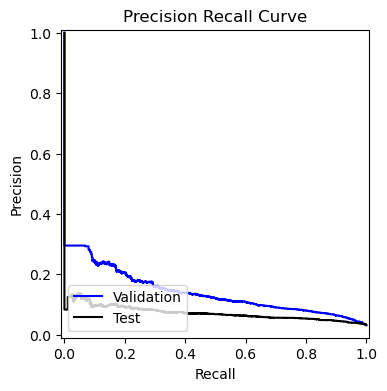

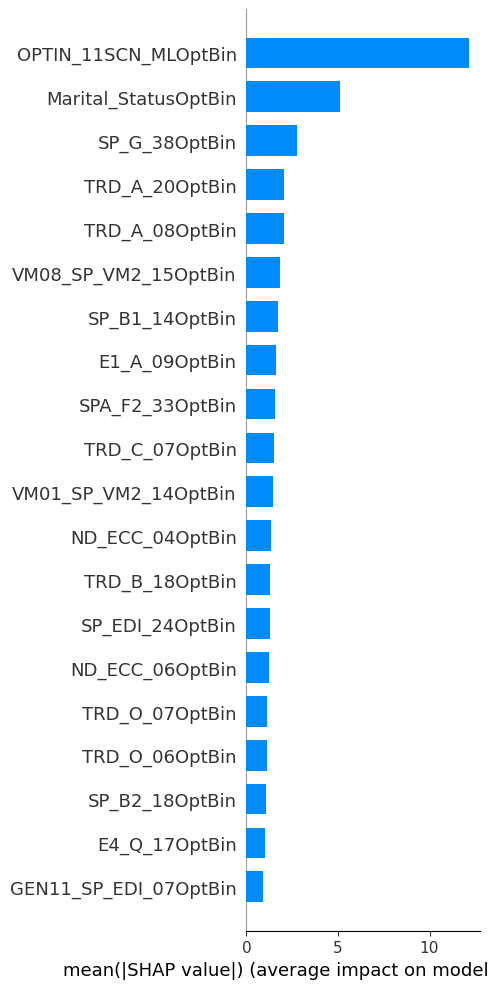

2024/05/23 17:52:38 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/05/23 17:52:38 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [81]:
RUN_NAME = '01-LogRegression-hyperparams_tunning'
with mlflow.start_run(run_name=RUN_NAME, log_system_metrics=True):
    res = search_hyper_params_and_log(
        run_name=RUN_NAME,
        data_dict=data_dict,
        cols_to_use=COLS_TO_USE,
        target_name=TARGET_BIN,
        distributions=PARAMS,
        n_iter=100,
        model=MODEL,
        custom_params_updates=update_solver_by_penalty,
        tags=None
    )

In [85]:
res.sort_values('PR_AUC', ascending=False).head()

,params,PR_AUC,GINI
26,"{'penalty': 'l2', 'C': 2.818484499495253, 'fit...",0.163632,0.628212
81,"{'penalty': 'l2', 'C': 3.2325742818922754, 'fi...",0.151033,0.642824
61,"{'penalty': 'l2', 'C': 12.687026894027277, 'fi...",0.150776,0.621439
84,"{'penalty': 'l1', 'C': 3.216161028349973, 'fit...",0.148457,0.640147
20,"{'penalty': 'elasticnet', 'C': 16.845695491899...",0.144337,0.651358


In [86]:
res.sort_values('GINI', ascending=False).head()

,params,PR_AUC,GINI
20,"{'penalty': 'elasticnet', 'C': 16.845695491899...",0.144337,0.651358
67,"{'penalty': 'elasticnet', 'C': 1.8057954010881...",0.136809,0.650685
47,"{'penalty': 'l1', 'C': 17.665605178377366, 'fi...",0.132347,0.650495
33,"{'penalty': 'l2', 'C': 1.2711670057204727, 'fi...",0.132091,0.643441
81,"{'penalty': 'l2', 'C': 3.2325742818922754, 'fi...",0.151033,0.642824


In [90]:
def compute_train_val_diff(data_dict: Dict[str, pd.DataFrame],
                           cols_to_use: List[str],
                           target_name: str,
                           cv_res: pd.DataFrame,
                           model: Any) -> pd.DataFrame:
    df_metrics = pd.DataFrame()
    for i, r in cv_res.iterrows():
        print(f"# {i + 1} / {cv_res.shape[0]-1}")
       
        # generate parameters
        params = r.params

        X_train = data_dict['df_train'][cols_to_use]
        Y_train = data_dict['df_train'][target_name]
        X_val = data_dict['df_val'][cols_to_use]
        Y_val = data_dict['df_val'][target_name]

        std_scaler = StandardScaler()
        std_scaler.fit(X_train)
        X_train = std_scaler.transform(X_train)
        X_val = std_scaler.transform(X_val)

        model_obj = model(**params)
        model_obj.fit(X_train, Y_train)
        y_train_pred = model_obj.predict_proba(X_train)[:, 1]
        y_val_pred = model_obj.predict_proba(X_val)[:, 1]

        roc_auc_train = roc_auc_score(Y_train.astype(int), y_train_pred)
        gini_train = 2 * roc_auc_train - 1

        roc_auc_val = roc_auc_score(Y_val.astype(int), y_val_pred)
        gini_val = 2 * roc_auc_val - 1

        precision, recall, _ = precision_recall_curve(Y_train.astype(int), y_train_pred)
        auc_train = auc(x=recall, y=precision)

        precision, recall, _ = precision_recall_curve(Y_val.astype(int), y_val_pred)
        auc_val = auc(x=recall, y=precision)

        df_metrics = pd.concat(
            (
                df_metrics, 
                pd.DataFrame(
                    {
                        'iter': [i],
                        'GINI_train': [gini_train],
                        'GINI_val': [gini_val],
                        'GINI_prcnt_chng': [(gini_val - gini_train) * 100 / gini_train],
                        'PR_AUC_train': [auc_train],
                        'PR_AUC_val': [auc_val],
                        'PR_AUC_prcnt_chng': [(auc_val - auc_train) * 100 / auc_train],
                        'params': [params]
                    }
                )
            )
        )
    return df_metrics

In [91]:
df_res = compute_train_val_diff(
    data_dict=data_dict,
    cols_to_use=COLS_TO_USE,
    target_name=TARGET_BIN,
    cv_res=res,
    model=MODEL
) 

# 1 / 99
# 2 / 99
# 3 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
The max_iter was reached which means the coef_ did not converge


# 4 / 99
# 5 / 99


The max_iter was reached which means the coef_ did not converge


# 6 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 7 / 99
# 8 / 99
# 9 / 99
# 10 / 99


The max_iter was reached which means the coef_ did not converge


# 11 / 99


The max_iter was reached which means the coef_ did not converge


# 12 / 99
# 13 / 99
# 14 / 99
# 15 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 16 / 99
# 17 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 18 / 99
# 19 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 20 / 99
# 21 / 99


The max_iter was reached which means the coef_ did not converge


# 22 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 23 / 99
# 24 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
The max_iter was reached which means the coef_ did not converge


# 25 / 99
# 26 / 99
# 27 / 99


The max_iter was reached which means the coef_ did not converge


# 28 / 99
# 29 / 99
# 30 / 99
# 31 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 32 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
The max_iter was reached which means the coef_ did not converge


# 33 / 99
# 34 / 99
# 35 / 99
# 36 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 37 / 99
# 38 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 39 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
The max_iter was reached which means the coef_ did not converge


# 40 / 99
# 41 / 99
# 42 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 43 / 99
# 44 / 99


The max_iter was reached which means the coef_ did not converge


# 45 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 46 / 99
# 47 / 99
# 48 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 49 / 99
# 50 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 51 / 99
# 52 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 53 / 99
# 54 / 99


The max_iter was reached which means the coef_ did not converge


# 55 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 56 / 99
# 57 / 99
# 58 / 99
# 59 / 99


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 60 / 99
# 61 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 62 / 99
# 63 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 64 / 99
# 65 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 66 / 99
# 67 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
The max_iter was reached which means the coef_ did not converge


# 68 / 99
# 69 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 70 / 99
# 71 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 72 / 99
# 73 / 99
# 74 / 99
# 75 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 76 / 99
# 77 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 78 / 99
# 79 / 99
# 80 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 81 / 99
# 82 / 99
# 83 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 84 / 99
# 85 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 86 / 99
# 87 / 99


The max_iter was reached which means the coef_ did not converge


# 88 / 99
# 89 / 99
# 90 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 91 / 99
# 92 / 99


The max_iter was reached which means the coef_ did not converge


# 93 / 99
# 94 / 99


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge


# 95 / 99
# 96 / 99


The max_iter was reached which means the coef_ did not converge
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.
'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


# 97 / 99
# 98 / 99
# 99 / 99
# 100 / 99


'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


In [108]:
df_res.sort_values('PR_AUC_val', ascending=False).head(10)

,iter,GINI_train,GINI_val,GINI_prcnt_chng,PR_AUC_train,PR_AUC_val,PR_AUC_prcnt_chng,params
0,26,0.707413,0.628212,-11.195792,0.137821,0.163632,18.727910,"{'penalty': 'l2', 'C': 2.818484499495253, 'fit..."
0,81,0.692380,0.642824,-7.157293,0.119386,0.151033,26.508022,"{'penalty': 'l2', 'C': 3.2325742818922754, 'fi..."
0,61,0.680317,0.621439,-8.654367,0.127550,0.150776,18.209102,"{'penalty': 'l2', 'C': 12.687026894027277, 'fi..."
0,84,0.679287,0.640147,-5.761961,0.132242,0.148457,12.261469,"{'penalty': 'l1', 'C': 3.216161028349973, 'fit..."
0,20,0.702812,0.651358,-7.321047,0.134094,0.144337,7.638234,"{'penalty': 'elasticnet', 'C': 16.845695491899..."
0,31,0.707431,0.622968,-11.939432,0.134748,0.143433,6.445195,"{'penalty': 'elasticnet', 'C': 13.021540510038..."
0,74,0.670677,0.586763,-12.511813,0.127425,0.140987,10.643340,"{'penalty': 'l1', 'C': 5.158832554303112, 'fit..."
0,69,0.686676,0.627615,-8.600964,0.144883,0.138584,-4.347696,"{'penalty': 'elasticnet', 'C': 4.4048209513109..."
0,73,0.669365,0.591533,-11.627740,0.119023,0.138201,16.113293,"{'penalty': 'l2', 'C': 4.181432414754274, 'fit..."
0,93,0.707112,0.642699,-9.109373,0.147416,0.137670,-6.610871,"{'penalty': 'elasticnet', 'C': 9.8503538763772..."


In [114]:
df_res.sort_values('GINI_val', ascending=False).head(20)

,iter,GINI_train,GINI_val,GINI_prcnt_chng,PR_AUC_train,PR_AUC_val,PR_AUC_prcnt_chng,params
0,20,0.702812,0.651358,-7.321047,0.134094,0.144337,7.638234,"{'penalty': 'elasticnet', 'C': 16.845695491899..."
0,67,0.701509,0.650685,-7.244926,0.133760,0.136809,2.278990,"{'penalty': 'elasticnet', 'C': 1.8057954010881..."
0,47,0.699003,0.650495,-6.939626,0.125358,0.132347,5.575496,"{'penalty': 'l1', 'C': 17.665605178377366, 'fi..."
0,33,0.706511,0.643441,-8.926922,0.135146,0.132091,-2.260355,"{'penalty': 'l2', 'C': 1.2711670057204727, 'fi..."
0,81,0.692380,0.642824,-7.157293,0.119386,0.151033,26.508022,"{'penalty': 'l2', 'C': 3.2325742818922754, 'fi..."
0,93,0.707112,0.642699,-9.109373,0.147416,0.137670,-6.610871,"{'penalty': 'elasticnet', 'C': 9.8503538763772..."
0,7,0.755100,0.641562,-15.036116,0.142715,0.124796,-12.556155,"{'penalty': 'l1', 'C': 0.14132610439434812, 'f..."
0,84,0.679287,0.640147,-5.761961,0.132242,0.148457,12.261469,"{'penalty': 'l1', 'C': 3.216161028349973, 'fit..."
0,39,0.756977,0.628794,-16.933474,0.138662,0.118798,-14.324907,"{'penalty': 'l1', 'C': 0.5083825348819038, 'fi..."
0,78,0.675697,0.628786,-6.942594,0.101709,0.124942,22.843105,"{'penalty': 'elasticnet', 'C': 6.7805958209740..."


In [96]:
def train_pred(data_dict: Dict[str, pd.DataFrame], 
              cols_to_use: List[str], 
              target_name: str, 
              model, 
              params,
              alias: Any) -> Any:
    X_train = data_dict['df_train_val'][cols_to_use]
    Y_train = data_dict['df_train_val'][target_name]

    X_test = data_dict['df_test'][cols_to_use]
    Y_test = data_dict['df_test'][target_name]

    std_scaler = StandardScaler()
    std_scaler.fit(X_train)
    X_train = std_scaler.transform(X_train)
    X_test = std_scaler.transform(X_test)

    model_obj = model(**params)
    model_obj.fit(X_train, Y_train)
    
    y_train_pred = model_obj.predict_proba(X_train)[:, 1]
    y_test_pred = model_obj.predict_proba(X_test)[:, 1]
    
    data_dict['df_train_val'][f'score{alias}'] = y_train_pred
    data_dict['df_test'][f'score{alias}'] = y_test_pred
    
    return (data_dict, model_obj)

In [100]:
df_res[df_res.iter == 20].params[0]

{'penalty': 'elasticnet',
 'C': 16.84569549189997,
 'fit_intercept': True,
 'class_weight': 'balanced',
 'random_state': 42,
 'n_jobs': -1,
 'solver': 'saga',
 'l1_ratio': 0.44975413336976566}

In [103]:
params = copy.deepcopy(df_res[df_res.iter == 20].params[0])

In [106]:
params['max_iter'] = 50000

In [107]:
data_dict, model = train_pred(
    data_dict=data_dict,
    cols_to_use=COLS_TO_USE,
    target_name=TARGET_BIN,
    model=MODEL,
    params=params,
    alias=''
)

The max_iter was reached which means the coef_ did not converge


In [110]:
params = copy.deepcopy(df_res[df_res.iter == 93].params[0])
params['max_iter'] = 50000
data_dict, model = train_pred(
    data_dict=data_dict,
    cols_to_use=COLS_TO_USE,
    target_name=TARGET_BIN,
    model=MODEL,
    params=params,
    alias=''
)

The max_iter was reached which means the coef_ did not converge


In [113]:
params = copy.deepcopy(df_res[df_res.iter == 74].params[0])
data_dict, model = train_pred(
    data_dict=data_dict,
    cols_to_use=COLS_TO_USE,
    target_name=TARGET_BIN,
    model=MODEL,
    params=params,
    alias=''
)

The max_iter was reached which means the coef_ did not converge


In [123]:
params = copy.deepcopy(df_res[df_res.iter == 7].params[0])
data_dict, model = train_pred(
    data_dict=data_dict,
    cols_to_use=COLS_TO_USE,
    target_name=TARGET_BIN,
    model=MODEL,
    params=params,
    alias=''
)

'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 12.


In [126]:
df_res[df_res.iter == 7]

,iter,GINI_train,GINI_val,GINI_prcnt_chng,PR_AUC_train,PR_AUC_val,PR_AUC_prcnt_chng,params
0,7,0.7551,0.641562,-15.036116,0.142715,0.124796,-12.556155,"{'penalty': 'l1', 'C': 0.14132610439434812, 'f..."


In [125]:
model.coef_

array([[-0.69944248, -0.4284628 , -0.5780283 ,  0.07225909,  0.16658237,
        -0.0767708 , -0.01332875, -0.13853262,  0.0222269 , -0.29743332,
         0.04935381,  0.08247774, -0.32564275, -0.03374324, -0.18562533,
        -0.23184774,  0.174464  ,  0.03949082, -0.17005844, -0.47704015,
         0.16581389,  0.096621  , -0.23287065, -0.08675505,  0.04130686,
        -0.30969918,  0.26857132,  0.06616298,  0.25186073,  0.08068184,
        -0.31085959,  0.17360754,  0.01623709, -0.11025578, -0.31515578,
         0.        ,  0.        ,  0.01766439, -0.23876721,  0.05461848,
        -0.00300952, -0.14571043,  0.        , -0.05101561,  0.17611797,
        -0.22539618,  0.33944555,  0.30392309, -0.14939079,  0.03764574]])

In [127]:
model.intercept_

array([0.03541165])

In [184]:
df_coeff = pd.DataFrame(
    {
        'Feature': COLS_TO_USE + ['Intercept'],
        'Coeff': np.append(model.coef_[0], model.intercept_)
    }
)
df_coeff

,Feature,Coeff
0,OPTIN_11SCN_MLOptBin,-0.699442
1,G5_ND_SPECIIOptBin,-0.428463
2,Marital_StatusOptBin,-0.578028
3,SP_F2_33OptBin,0.072259
4,AFF_B_09_01OptBin,0.166582
5,TRD_A_20OptBin,-0.076771
6,TRD_A_08OptBin,-0.013329
7,VM01_SP_VM2_15OptBin,-0.138533
8,GEN11_SP_N_92OptBin,0.022227
9,SP_EDI_24OptBin,-0.297433


In [185]:
df_coeff[df_coeff.Coeff == 0]

,Feature,Coeff
35,SP_I_63_01OptBin,0.0
36,SP_B2_20OptBin,0.0
42,VM08_SP_VM2_20OptBin,0.0


In [ ]:
for col in COLS_TO_USE:
    if col not in df_coeff[df_coeff.Coeff == 0].Feature.values:
        print(f'"{col}",')

In [129]:
from sklearn.metrics import precision_score, recall_score

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='score', ylabel='Density'>

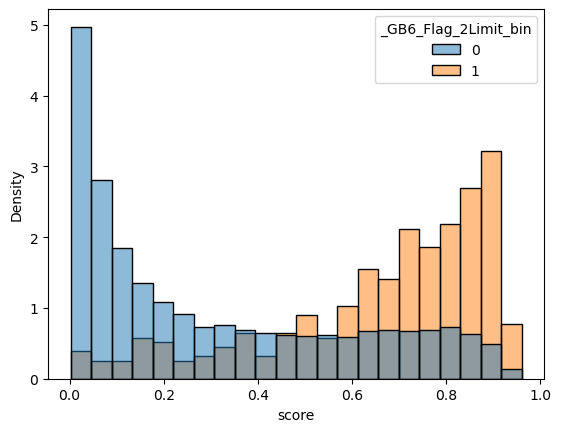

In [143]:
sns.histplot(x=data_dict['df_test']['score'], hue=data_dict['df_test'][TARGET_BIN], common_norm=False, stat='density')

In [153]:
from utils.metrics_by_quantile import MetricsByQuantile

In [171]:
temp = pd.merge(
    pd.DataFrame(pd.qcut(data_dict['df_test']['score'].round(3).values, q=200, duplicates='drop').value_counts().sort_index(ascending=False).cumsum()),
    pd.DataFrame(pd.qcut(data_dict['df_test']['score'].round(3).values, q=200, duplicates='drop').value_counts().sort_index(ascending=False)),
    left_index=True, right_index=True
)

,count_x,count_y,%
"(0.92, 0.96]",55,55,0.49
"(0.907, 0.92]",112,57,0.99
"(0.898, 0.907]",170,58,1.50
"(0.891, 0.898]",220,50,1.95
"(0.884, 0.891]",274,54,2.43
...,...,...,...
"(0.008, 0.009]",11064,93,97.93
"(0.007, 0.008]",11122,58,98.44
"(0.006, 0.007]",11180,58,98.96
"(0.005, 0.006]",11235,55,99.44


In [178]:
m = MetricsByQuantile(metrics=["quantiles_analytics"])
r = m.compute(
    y_true=data_dict['df_test'][TARGET_BIN].reset_index(drop=True), 
    y_pred=data_dict['df_test']['score'].round(3).reset_index(drop=True), 
    list_of_metrics = [
        "cum_precision_by_quantile", "cum_recall_by_quantile", 
        "precision_by_quantile", "recall_by_quantile",
    ], 
    n_quantiles = 200
)
df_deciles = r["other"]["quantiles_analytics"]
df_deciles.head(50)

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,% of total population,Cumulative % of total population,Total,Bad,Cumulative Bad,Quantile,#Quantile,Cumulative Precision,Cumulative Recall,Precision,Recall,Scores
0,0.49,0.49,55,9,9,"(0.92, 0.96]",195,16.363636,2.521008,16.363636,2.521008,0.92--0.96
1,0.50,0.99,57,13,22,"(0.907, 0.92]",194,19.642857,6.162465,22.807018,3.641457,0.907--0.92
2,0.51,1.50,58,12,34,"(0.898, 0.907]",193,20.000000,9.523810,20.689655,3.361345,0.898--0.907
3,0.44,1.95,50,5,39,"(0.891, 0.898]",192,17.727273,10.924370,10.000000,1.400560,0.891--0.898
4,0.48,2.43,54,10,49,"(0.884, 0.891]",191,17.883212,13.725490,18.518519,2.801120,0.884--0.891
5,0.54,2.97,61,10,59,"(0.877, 0.884]",190,17.611940,16.526611,16.393443,2.801120,0.877--0.884
6,0.51,3.48,58,8,67,"(0.868, 0.877]",189,17.048346,18.767507,13.793103,2.240896,0.868--0.877
7,0.44,3.92,50,8,75,"(0.861, 0.868]",188,16.930023,21.008403,16.000000,2.240896,0.861--0.868
8,0.54,4.46,61,12,87,"(0.853, 0.861]",187,17.261905,24.369748,19.672131,3.361345,0.853--0.861
9,0.53,4.99,60,6,93,"(0.846, 0.853]",186,16.489362,26.050420,10.000000,1.680672,0.846--0.853
